In [97]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [98]:
with open ('D:/Download/names.txt', 'r') as f:
    names = f.read().splitlines()
az = sorted(set(''.join(names)))
stoi = {s:i+1 for i, s in enumerate(az)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
random.seed(42)
random.shuffle(names)

In [100]:
context_size = 3

def build_set(any_names):
    X, Y = [], []
    for name in any_names:
        context = [0]*context_size
        for chs in name + '.':
            ix = stoi[chs]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [101]:
percent_tr = 0.8
percent_dev = 0.9
to1 = int(percent_tr * len(names))
to2 = int(percent_dev * len(names))
Xtr, Ytr = build_set(names[:to1])
Xdev, Ydev = build_set(names[to1:to2])
Xte, Yte = build_set(names[to2:])

In [187]:
# not changed: range_i, context_size, convergence time

In [188]:
# changed: lr, n_emb, mini_batch, n_hidden, decay, linear projection (skip connection), residual connection

In [182]:
range_i = 200001
mini_batch = 64 # 64
len_abet = len(stoi) # = 27
n_emb = 16 # 16
n_hidden = 200 # 200
lr = 0.1 # 0.1
lr_decay = 0.03 # 0.03
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(len_abet, n_emb, generator = g)
S = torch.randn(context_size*n_emb, len_abet, generator = g) * 0.01 # Skip connection 
W1 = torch.randn(context_size*n_emb, n_hidden, generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn(n_hidden, len_abet, generator = g)* 0.01
b2 = torch.randn(len_abet, generator = g) * 0.01
parameters = [C, W1, b1, W2, b2]
parameters.append(S)
for p in parameters:
    p.requires_grad = True
p_num = sum(p.nelement() for p in parameters)
print(p_num)
lossi = []
lri = []
lrei = []
iteri = []
losslogi = []
lre = torch.linspace(-3, 0, range_i)
lrs = 10**lre

16955


In [183]:
for i in range (range_i):
    ix = torch.randint(Xtr.shape[0], (mini_batch,), generator = g)
    emb = C[Xtr[ix]]
    embs = emb.view(mini_batch, -1) # (32,48)
    h = torch.tanh(embs @ W1 + b1) # (32, 30) @ (30, 200) = (32, 200)
    logits = h @ W2 + b2 # (32, 200) @ (200, 27) = (32, 27)
    logits += embs @ S # linear projection it's residual-like connection
    loss_tr_batch = F.cross_entropy(logits, Ytr[ix])
    if i%int(range_i/10) == 0:
        print (i, loss_tr_batch, lr)
    for p in parameters:
        p.grad = None
    loss_tr_batch.backward()
    lr = lr if i < range_i//2 else lr_decay
    # lr = lrs[i]
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
        # LOGS
        # lri.append(lr)
        # lrei.append(lre[i])
        # lossi.append(loss_tr_batch.item())
        # losslogi.append(loss_tr_batch.log10().item())
        # iteri.append(i)

0 tensor(3.2562, grad_fn=<NllLossBackward0>) 0.1
20000 tensor(2.1831, grad_fn=<NllLossBackward0>) 0.1
40000 tensor(2.2410, grad_fn=<NllLossBackward0>) 0.1
60000 tensor(2.3394, grad_fn=<NllLossBackward0>) 0.1
80000 tensor(2.0558, grad_fn=<NllLossBackward0>) 0.1
100000 tensor(2.1482, grad_fn=<NllLossBackward0>) 0.1
120000 tensor(2.0130, grad_fn=<NllLossBackward0>) 0.03
140000 tensor(2.1223, grad_fn=<NllLossBackward0>) 0.03
160000 tensor(1.9242, grad_fn=<NllLossBackward0>) 0.03
180000 tensor(1.7396, grad_fn=<NllLossBackward0>) 0.03
200000 tensor(2.1020, grad_fn=<NllLossBackward0>) 0.03


In [189]:
emb = C[Xtr]
embs = emb.view(Xtr.shape[0], -1)
h = torch.tanh(embs @ W1 + b1) # (32, 30) @ (30, 200) = (32, 200)
logits = h @ W2 + b2# (32, 200) @ (200, 27) = (32, 27)
logits += embs @ S
loss_tr = F.cross_entropy(logits, Ytr)
loss_tr

tensor(2.0474, grad_fn=<NllLossBackward0>)

In [190]:
# 200K
# 2.0530
# with S: 2.0478

In [191]:
# 2.1260

# range_i = 10K; lr = 0.05; loss_tr = 2.5626
# range_i = 10K; lr = 0.06; loss_tr = 2.5543
# range_i = 10K; lr = 0.07; loss_tr = 2.5766
# range_i = 10K; lr = 0.1; loss_tr = 2.5894
# range_i = 10K; lr = 0.13; loss_tr = 2.7750

# range_i = 50K; lr = 0.05; loss_tr = 2.3248
# range_i = 50K; lr = 0.06; loss_tr = 2.3231
# range_i = 50K; lr = 0.07; loss_tr = 2.3139
# range_i = 50K; lr = 0.1; loss_tr = 2.3220

# range_i = 50K; lr = 0.06; lr_decay = 0.01; loss_tr = 2.2674

# range_i = 200K; lr = 0.06; lr_decay = 0.01; loss_tr = 2.1562
# range_i = 200K; lr = 0.1; lr_decay = 0.01; loss_tr = 2.1241

# range_i = 200K; h=250; lr = 0.1; lr_decay = 0.01; loss_tr = 2.1149
# range_i = 200K; h=300; lr = 0.1; lr_decay = 0.01; loss_tr = 2.1277

# BEST = 2.0809

In [192]:
emb = C[Xdev]
embs = emb.view(Xdev.shape[0], -1)
h = torch.tanh(embs @ W1 + b1) # (32, 30) @ (30, 200) = (32, 200)
logits = h @ W2 + b2 # (32, 200) @ (200, 27) = (32, 27)
logits += embs @ S
loss_dev = F.cross_entropy(logits, Ydev)
loss_dev

tensor(2.1289, grad_fn=<NllLossBackward0>)

In [194]:
# 200K
# 2.1327
# with S: 2.1305

In [166]:
# range_i = 10K; lr = 0.05; loss_dev = 2.5824
# range_i = 10K; lr = 0.06; loss_dev = 2.5726
# range_i = 10K; lr = 0.07; loss_dev = 2.5924
# range_i = 10K; lr = 0.1; loss_dev = 2.6082
# range_i = 10K; lr = 0.13; loss_dev = 2.7970

# range_i = 50K; lr = 0.05; loss_dev = 2.3442
# range_i = 50K; lr = 0.06; loss_dev = 2.3398
# range_i = 50K; lr = 0.07; loss_dev = 2.3409
# range_i = 50K; lr = 0.1; loss_dev = 2.3469

# range_i = 50K; lr = 0.06; lr_decay = 0.01; loss_dev = 2.2822

# range_i = 200K; lr = 0.06; lr_decay = 0.01; loss_dev = 2.1864
# range_i = 200K; lr = 0.1; lr_decay = 0.01; loss_dev = 2.1642
# range_i = 200K; emb = 12; lr = 0.1; lr_decay = 0.01; loss_dev = 2.1632 
# range_i = 200K; emb = 12; lr = 0.1; lr_decay = 0.01; loss_dev = 2.1483 

# range_i = 200K; h = 250; lr = 0.1; lr_decay = 0.01; loss_dev = 2.1741
# range_i = 200K; h = 300; lr = 0.1; lr_decay = 0.01; loss_dev = 2.1991

# BEST = 2.1295

In [206]:
# E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
# E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
# E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?
# Answer 01: [W2, b2, S] * 0.01 
# Answer 02: -torch.log(torch.tensor(1/27)) = 3.2958
# Answer 03: I build linear projection logits += embs @ S. in paper use y = b+W*x+U*tanh(d+H*x) it's veru simmilar residual connections y=F(x)+x.
# But there y = F(x) + Wx + b, where F(x) = U*h and h = tanh(d + H*x)
# that is, i transformed x so that it could be added to F(x)

In [196]:
-torch.log(torch.tensor(1/27)) # 3.2958

tensor(3.2958)

In [197]:
# plt.plot(lri, lossi)

In [198]:
# plt.plot(lrei, lossi)

In [199]:
# plt.plot(lri, lossi)
# plt.minorticks_on()  
# plt.grid('minor')

In [200]:
# plt.plot(lrei, lossi)
# plt.minorticks_on()

In [201]:
# plt.plot(iteri, losslogi)

In [202]:
# plt.plot(iteri, lossi)

In [203]:
g = torch.Generator().manual_seed(2147483647)
with torch.no_grad():
    for k in range(10):
        out = []
        context = context_size * [0]
        while True:
            emb = C[context]
            embs = emb.view(-1, context_size*n_emb)
            h = torch.tanh(embs @ W1 + b1)
            logits = h @ W2 + b2
            logits += embs @ S
            probs = F.softmax(logits, 1)
            next_ix = torch.multinomial(probs, 1, replacement = True, generator = g).item()
            context = context[1:] + [next_ix]
            out.append(itos[next_ix])
            if next_ix == 0:
                break
        print (''.join(out))

ter.
maleah.
makilah.
tyra.
kalissana.
noluwak.
kata.
kremiyah.
javer.
goton.


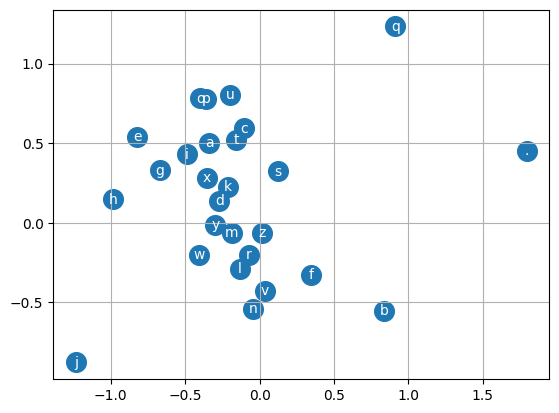

In [517]:
plt.plot(figsize=(8,8))
plt.scatter(C.data[:,0], C.data[:,1], s=200)
for q in range(len_abet):
    plt.text(C[q,0].data, C[q,1].data, itos[q], va = 'center', ha = 'center', color = 'white')
plt.grid('minor')

In [207]:
# evaluation test set loss
emb = C[Xte]
embs = emb.view(Xte.shape[0], -1)
h = torch.tanh(embs @ W1 + b1) # (32, 30) @ (30, 200) = (32, 200)
logits = h @ W2 + b2# (32, 200) @ (200, 27) = (32, 27)
logits += embs @ S
loss_te = F.cross_entropy(logits, Yte)
loss_te

tensor(2.1304, grad_fn=<NllLossBackward0>)

In [205]:
# TEST LOSS = 2.1304